In [23]:
import torch
import torch.autograd as autograd

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
from FCN import FCN
from tools import *

In [3]:
%matplotlib inline

In [4]:
def partial_diff_equation(f, g):
    f_x_y = autograd.grad(f,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True)[0] #first derivative
    f_xx_yy = autograd.grad(f_x_y,g,torch.ones(g.shape), create_graph=True)[0]#second derivative

    f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
    f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

    u = f_xx + f_yy # loss equation
    u = u.float()

    return u

## Simplest Case

In [5]:
X, Y, T = generate_domain()
X_train, T_train, X_test, X_train_Nu, T_train_Nu = generate_BC(X, Y, T, squareHasHole = False)
X_train_PDE = generate_PDE(squareHasHole = False)

x = X[:,0]
y = Y[0,:]

/Users/thyagocapitanio/anaconda3/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
layers = np.array([2,32,32,32,32,32,32,32,32,1]) #8 hidden layers

In [7]:
PINN = FCN(layers, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_simple.pt'))

<All keys matched successfully>

In [8]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (500, 500)))

In [98]:
def pplot(u_pred,lossTensor, num_ticks = 11):
    plt.close()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
    fig.tight_layout(pad = 5)

    num_ticks = 11
    # number of points in x and y
    nx = len(x)
    ny = len(y)
    # the index of the position of yticks
    yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)

    fmt = lambda x, pos: '{:.2f}'.format(x/nx, pos)

    sns.heatmap(u_pred, 
                ax = ax1, 
                cbar_kws={'label': r'$T^*$', 'shrink': 0.8},
                square = True)
    
    ax1.invert_yaxis()
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)

    ax1.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax1.set_title('Temperature')

    sns.heatmap(lossTensor,
                ax = ax2,
                vmin = -.15,
                vmax = .15,
                cmap = "vlag",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True)
    
    ax2.invert_yaxis()
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)

    ax2.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax2.set_title('Loss')

    plt.show()

In [67]:
lossTensor = PINN.lossTensor(X_test)

lossTensor = np.reshape(lossTensor.detach().numpy(), (500,500))

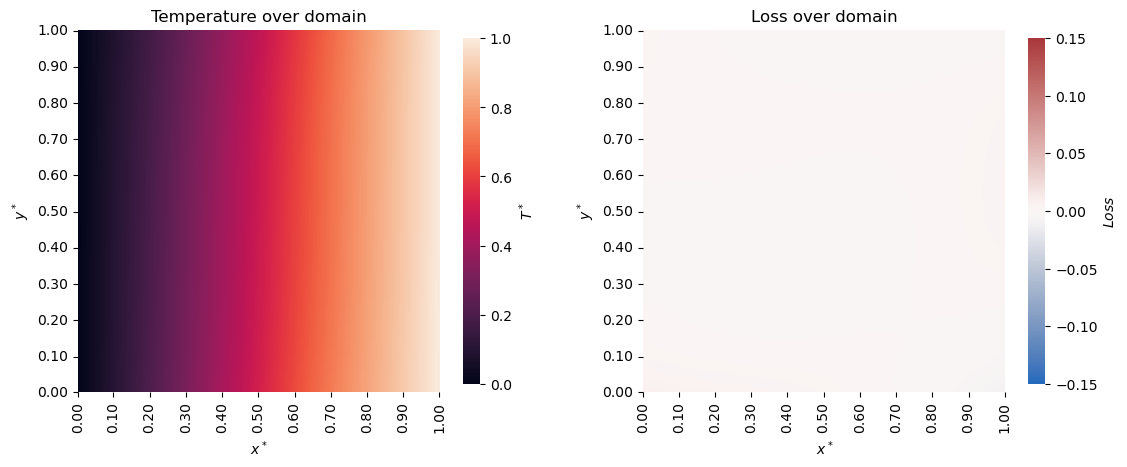

In [99]:
pplot(u_pred, lossTensor)

<Axes: >

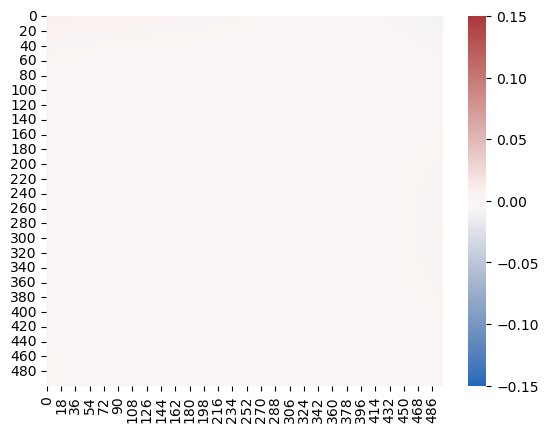

In [43]:
sns.heatmap(lossTensor,
            vmin = -.15,
            vmax = .15,
            cmap = "vlag")

## Square With Hole

In [33]:
layers = np.array([2,48,48,48,48,48,48,48,48,1]) #8 hidden layers

In [34]:
X, Y, T = generate_domain()
X_train, T_train, X_test, X_train_Nu, T_train_Nu = generate_BC(X, Y, T, squareHasHole = True)
X_train_PDE = generate_PDE(squareHasHole = True)

x = X[:,0]
y = Y[0,:]

In [35]:
PINN = FCN(layers, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
PINN.load_state_dict(torch.load('./PINN_holed.pt'))

<All keys matched successfully>

In [36]:
u_pred = PINN.forward(X_test)
u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (200, 200)))

In [37]:
u_pred.shape

(200, 200)

In [38]:
mask = isNotInCircleTensorOrder2(u_pred, x, y)

<AxesSubplot: >

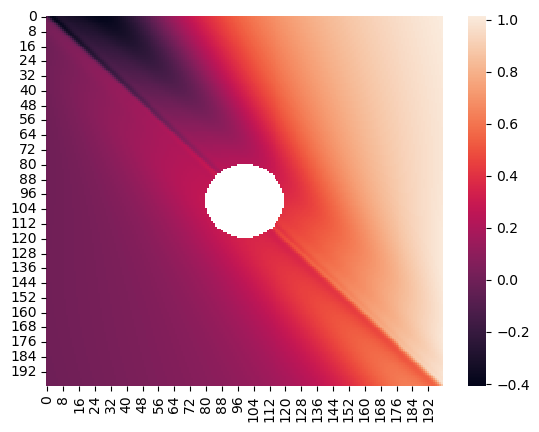

In [39]:
sns.heatmap(u_pred, mask = (1 - mask))

In [40]:
lossTensor = PINN.lossTensor(X_test)

In [41]:
lossTensor.shape

torch.Size([40000, 1])

In [42]:
lossTensor_2 = np.reshape(lossTensor.detach().numpy(), (200,200))

<AxesSubplot: >

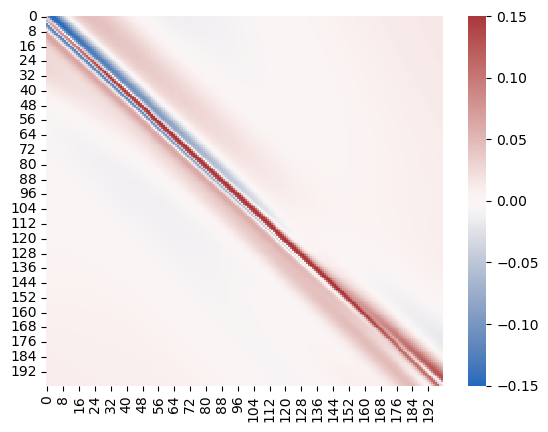

In [43]:
lossTensor = PINN.lossTensor(X_test)

lossTensor_2 = np.reshape(lossTensor.detach().numpy(), (200,200))

sns.heatmap(lossTensor_2,
            vmin = -.15,
            vmax = .15,
            cmap = "vlag")